# Hard Drive Failure Prediction — Baseline & LightGBM Models

This notebook loads engineered features from SageMaker Feature Store, trains a **baseline Logistic Regression** model (using only SMART attributes) and a **LightGBM** model (adding review-sentiment features), then compares their performance.

## 1. Environment Setup

Initialize AWS session, SageMaker Feature Store client, and load configuration from `.env`.

In [3]:
import os
import boto3
import pandas as pd
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from dotenv import load_dotenv

# Load environment variables
ENV_PATH = ".env"
load_dotenv(ENV_PATH)

# Get S3 bucket and region
bucket = os.getenv("BUCKET_NAME")
session = boto3.session.Session()
region = session.region_name

print(f"Bucket: {bucket}")
print(f"Region: {region}")

# Initialize SageMaker Feature Store session
sagemaker_session = sagemaker.Session()
role = os.getenv("SAGEMAKER_ROLE")
feature_store_session = Session(
    boto_session=session,
    sagemaker_client=boto3.client('sagemaker', region_name=region),
    sagemaker_featurestore_runtime_client=boto3.client('sagemaker-featurestore-runtime', region_name=region)
)

print(f"\nSageMaker Role: {role}")
print(f"Feature Store Session initialized")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket: mlops-backblaze-4263963c-us-east-1
Region: us-east-1

SageMaker Role: arn:aws:iam::173448391640:role/LabRole
Feature Store Session initialized


## 2. Feature Group Names

Load the names of the four Feature Groups (train / validation / test / production) from environment variables.

In [4]:
# Load Feature Group names from .env
feature_group_train = os.getenv("FEATURE_GROUP_TRAIN")
feature_group_val = os.getenv("FEATURE_GROUP_VAL")
feature_group_test = os.getenv("FEATURE_GROUP_TEST")
feature_group_prod = os.getenv("FEATURE_GROUP_PROD")

print("="*80)
print("FEATURE GROUP NAMES FROM .ENV")
print("="*80)
print(f"Training:     {feature_group_train}")
print(f"Validation:   {feature_group_val}")
print(f"Test:         {feature_group_test}")
print(f"Production:   {feature_group_prod}")
print("="*80)


FEATURE GROUP NAMES FROM .ENV
Training:     backblaze-hdd-failure-20260215-151418-train
Validation:   backblaze-hdd-failure-20260215-151418-validation
Test:         backblaze-hdd-failure-20260215-151418-test
Production:   backblaze-hdd-failure-20260215-151418-production


## 3. Feature Group Loader

Define a helper function that reads a SageMaker Feature Group directly from its S3-backed offline store (Parquet files), dropping internal metadata columns.

In [5]:
def load_feature_group_to_dataframe(feature_group_name, feature_store_session, use_offline_store=False):
    """
    Load a Feature Group from SageMaker Feature Store into a pandas DataFrame.
    
    Parameters:
    -----------
    feature_group_name : str
        Name of the feature group to load
    feature_store_session : sagemaker.Session
        SageMaker session for Feature Store
    use_offline_store : bool
        If True, use Athena to query offline store. If False, read from S3 parquet directly.
    
    Returns:
    --------
    pd.DataFrame : DataFrame containing all records from the feature group
    """
    import time
    from sagemaker.feature_store.feature_group import FeatureGroup
    
    print(f"\nLoading Feature Group: {feature_group_name}")
    
    # Create Feature Group object
    feature_group = FeatureGroup(
        name=feature_group_name,
        sagemaker_session=feature_store_session
    )
    
    # Check status
    try:
        description = feature_group.describe()
        status = description.get('FeatureGroupStatus')
        print(f"  Status: {status}")
        
        if status != 'Created':
            print(f"  ⚠ Warning: Feature Group is not in 'Created' state")
            return None
    except Exception as e:
        print(f"  ✗ Error: Feature Group not found - {str(e)[:100]}")
        return None
    
    if use_offline_store:
        # Use Athena query to retrieve data from offline store
        query_string = f'SELECT * FROM "{feature_group_name}"'
        
        print(f"  Querying offline store via Athena...")
        print(f"  Query: {query_string}")
        
        try:
            # Create Athena query
            athena_query = feature_group.athena_query()
            
            # Set database and table
            athena_query.run(
                query_string=query_string,
                output_location=f"s3://{bucket}/athena-results/"
            )
            
            # Wait for query to complete
            athena_query.wait()
            
            # Get results as DataFrame
            df = athena_query.as_dataframe()
            
            print(f"  ✓ Loaded {len(df):,} records")
            print(f"  Columns: {list(df.columns)}")
            
            return df
            
        except Exception as e:
            print(f"  ✗ Error loading data via Athena: {str(e)[:200]}")
            print(f"\n  Note: Offline store data may take a few minutes to be available.")
            print(f"  Trying direct S3 read instead...")
    
    # Read directly from S3 parquet files (faster and works immediately)
    try:
        print(f"  Reading parquet files from S3...")
        
        # Get S3 URI for offline store - use the resolved URI from description
        offline_store_config = description.get('OfflineStoreConfig', {})
        resolved_output_s3_uri = offline_store_config.get('S3StorageConfig', {}).get('ResolvedOutputS3Uri', '')
        
        if not resolved_output_s3_uri:
            # Fallback: construct from bucket  
            resolved_output_s3_uri = f"s3://{bucket}/feature-store/{feature_group_name}"
        
        # The resolved URI already points to the base path; parquet files are in /data subdirectory
        # Check if it already ends with /data, if not append it
        if resolved_output_s3_uri.endswith('/data'):
            data_s3_uri = resolved_output_s3_uri
        else:
            data_s3_uri = f"{resolved_output_s3_uri}/data"
        
        print(f"  S3 Path: {data_s3_uri}")
        
        # Read parquet files using pandas
        import pyarrow.parquet as pq
        import pyarrow.dataset as ds
        
        # Read the dataset (partitioned by year/month/day/hour)
        dataset = ds.dataset(data_s3_uri, format='parquet', partitioning='hive')
        df = dataset.to_table().to_pandas()
        
        # Drop internal columns and partition columns
        columns_to_drop = [col for col in df.columns if col in ['write_time', 'api_invocation_time', 'is_deleted', 'year', 'month', 'day', 'hour']]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
        
        print(f"  ✓ Loaded {len(df):,} records")
        print(f"  Columns: {list(df.columns)[:10]}..." if len(df.columns) > 10 else f"  Columns: {list(df.columns)}")
        
        return df
        
    except Exception as e:
        print(f"  ✗ Error loading data from S3: {str(e)[:200]}")
        import traceback
        traceback.print_exc()
        return None


## 4. Verify S3 Structure

Sanity-check that the expected Feature Store directories and Parquet files exist in S3 before attempting to load data.

In [6]:
# Check the actual S3 structure for one feature group
s3_client = boto3.client('s3', region_name=region)

print("Checking S3 structure for feature store...")
prefix = "feature-store/"
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix, Delimiter='/', MaxKeys=10)

print(f"\nTop-level directories under {prefix}:")
for item in response.get('CommonPrefixes', []):
    print(f"  {item['Prefix']}")

# Check one feature group in detail
if feature_group_train:
    fg_prefix = f"feature-store/{feature_group_train}/"
    print(f"\nChecking structure under {fg_prefix}:")
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=fg_prefix, MaxKeys=20)
    
    for obj in response.get('Contents', [])[:10]:
        print(f"  {obj['Key']}")


Checking S3 structure for feature store...

Top-level directories under feature-store/:
  feature-store/backblaze-hdd-failure-20260208-201907-production/
  feature-store/backblaze-hdd-failure-20260208-201907-test/
  feature-store/backblaze-hdd-failure-20260208-201907-train/
  feature-store/backblaze-hdd-failure-20260208-201907-validation/
  feature-store/backblaze-hdd-failure-20260215-150622-production/
  feature-store/backblaze-hdd-failure-20260215-150622-test/
  feature-store/backblaze-hdd-failure-20260215-150622-train/
  feature-store/backblaze-hdd-failure-20260215-150622-validation/
  feature-store/backblaze-hdd-failure-20260215-151418-production/
  feature-store/backblaze-hdd-failure-20260215-151418-test/

Checking structure under feature-store/backblaze-hdd-failure-20260215-151418-train/:
  feature-store/backblaze-hdd-failure-20260215-151418-train/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260215-151418-train-1771168483/backblaze-hdd-failure-20260215-1

## 5. Load All Feature Groups

Read the training, validation, test, and production Feature Groups into DataFrames and print a loading summary (shape, failure counts).

In [7]:
# Load all feature groups into dataframes
print("="*80)
print("LOADING FEATURE GROUPS INTO DATAFRAMES")
print("="*80)

# Load training data
df_train = load_feature_group_to_dataframe(feature_group_train, feature_store_session)

# Load validation data
df_val = load_feature_group_to_dataframe(feature_group_val, feature_store_session)

# Load test data
df_test = load_feature_group_to_dataframe(feature_group_test, feature_store_session)

# Load production data
df_prod = load_feature_group_to_dataframe(feature_group_prod, feature_store_session)

print("\n" + "="*80)
print("LOADING SUMMARY")
print("="*80)

datasets = {
    'Training': df_train,
    'Validation': df_val,
    'Test': df_test,
    'Production': df_prod
}

for name, df in datasets.items():
    if df is not None:
        print(f"\n{name} Dataset:")
        print(f"  Shape: {df.shape}")
        print(f"  Failures: {df['failure'].sum() if 'failure' in df.columns else 'N/A'}")
    else:
        print(f"\n{name} Dataset: Failed to load")


LOADING FEATURE GROUPS INTO DATAFRAMES

Loading Feature Group: backblaze-hdd-failure-20260215-151418-train
  Status: Created
  Reading parquet files from S3...
  S3 Path: s3://mlops-backblaze-4263963c-us-east-1/feature-store/backblaze-hdd-failure-20260215-151418-train/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260215-151418-train-1771168483/data
  ✓ Loaded 130,644 records
  Columns: ['record_id', 'event_time', 'serial_number', 'date', 'pct_one_star', 'pct_two_star', 'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw']...

Loading Feature Group: backblaze-hdd-failure-20260215-151418-validation
  Status: Created
  Reading parquet files from S3...
  S3 Path: s3://mlops-backblaze-4263963c-us-east-1/feature-store/backblaze-hdd-failure-20260215-151418-validation/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260215-151418-validation-1771168484/data
  ✓ Loaded 32,661 records
  Columns: ['record_id', 'event_time', 'serial_number'

## 6. Dataset Summary (Pre-Deduplication)

Display shape, failure rates, and feature columns for each split **before** deduplication.

In [8]:
def summarize_dataset(df_train, df_val, df_test, df_prod):
    # Prepare X and y datasets for modeling
    feature_cols = ['pct_one_star', 'pct_two_star', 'smart_5_raw', 
                    'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

    if df_train is not None and df_val is not None and df_test is not None:
        print("="*80)
        print("PREPARING FEATURE MATRICES AND TARGET VECTORS")
        print("="*80)
        
        # Training data
        X_train = df_train[feature_cols].copy()
        y_train = df_train['failure'].copy()
        
        # Validation data
        X_val = df_val[feature_cols].copy()
        y_val = df_val['failure'].copy()
        
        # Test data
        X_test = df_test[feature_cols].copy()
        y_test = df_test['failure'].copy()
        
        # Production data (if needed)
        if df_prod is not None:
            X_prod = df_prod[feature_cols].copy()
            y_prod = df_prod['failure'].copy()
        
        print(f"\nTraining Set:")
        print(f"  X_train: {X_train.shape}")
        print(f"  y_train: {y_train.shape}")
        print(f"  Failure rate: {y_train.sum() / len(y_train) * 100:.4f}%")
        
        print(f"\nValidation Set:")
        print(f"  X_val: {X_val.shape}")
        print(f"  y_val: {y_val.shape}")
        print(f"  Failure rate: {y_val.sum() / len(y_val) * 100:.4f}%")
        
        print(f"\nTest Set:")
        print(f"  X_test: {X_test.shape}")
        print(f"  y_test: {y_test.shape}")
        print(f"  Failure rate: {y_test.sum() / len(y_test) * 100:.4f}%")
        
        if df_prod is not None:
            print(f"\nProduction Set:")
            print(f"  X_prod: {X_prod.shape}")
            print(f"  y_prod: {y_prod.shape}")
            print(f"  Failure rate: {y_prod.sum() / len(y_prod) * 100:.4f}%")
        
        print(f"\n" + "="*80)
        print(f"Feature columns ({len(feature_cols)}):")
        for i, col in enumerate(feature_cols, 1):
            print(f"  {i}. {col}")
        
    else:
        print("\n⚠ Warning: Not all datasets loaded successfully. Cannot prepare feature matrices.")

summarize_dataset(df_train, df_val, df_test, df_prod)

PREPARING FEATURE MATRICES AND TARGET VECTORS

Training Set:
  X_train: (130644, 7)
  y_train: (130644,)
  Failure rate: 0.0337%

Validation Set:
  X_val: (32661, 7)
  y_val: (32661,)
  Failure rate: 0.0490%

Test Set:
  X_test: (32661, 7)
  y_test: (32661,)
  Failure rate: 0.0276%

Production Set:
  X_prod: (130646, 7)
  y_prod: (130646,)
  Failure rate: 0.0467%

Feature columns (7):
  1. pct_one_star
  2. pct_two_star
  3. smart_5_raw
  4. smart_187_raw
  5. smart_188_raw
  6. smart_197_raw
  7. smart_198_raw


## 10. Baseline Model — Logistic Regression

Train a simple **Logistic Regression** baseline using only the five SMART features (`smart_5_raw`, `smart_187_raw`, `smart_188_raw`, `smart_197_raw`, `smart_198_raw`), dropping the `pct_*` review-sentiment features.

**Threshold tuning strategy:** Instead of the default 0.5 threshold, the decision threshold is tuned on the validation set to **guarantee ≥ 70 % recall** on the positive (failure) class, then among all qualifying thresholds the one with the **fewest false positives** is selected.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, recall_score, precision_score,
    average_precision_score
)
import numpy as np

# ── Simple Baseline: Logistic Regression (SMART features only) ──────────────
print("="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)

# Use only SMART features (drop pct_one_star, pct_two_star)
baseline_feature_cols = ['smart_5_raw', 'smart_187_raw', 'smart_188_raw',
                         'smart_197_raw', 'smart_198_raw']

X_train_bl = df_train[baseline_feature_cols].copy()
y_train_bl = df_train['failure'].astype(int).copy()
X_val_bl   = df_val[baseline_feature_cols].copy()
y_val_bl   = df_val['failure'].astype(int).copy()
X_test_bl  = df_test[baseline_feature_cols].copy()
y_test_bl  = df_test['failure'].astype(int).copy()

print(f"\nFeatures: {baseline_feature_cols}")
print(f"Training set: {X_train_bl.shape}")
print(f"Failure rate: {y_train_bl.mean()*100:.4f}%")

# Train simple logistic regression (no scaling, use class_weight for imbalance)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_bl, y_train_bl)

print(f"\nModel coefficients:")
for feat, coef in zip(baseline_feature_cols, lr_model.coef_[0]):
    print(f"  {feat:20s}: {coef:+.6f}")

# ── Threshold Tuning: ≥70% Recall with Minimal False Positives ─────────────
TARGET_RECALL_BL = 0.70

# Get predicted probabilities on validation set for threshold tuning
y_val_prob_bl = lr_model.predict_proba(X_val_bl)[:, 1]

# Compute precision-recall curve on validation set
precisions_bl, recalls_bl, thresholds_bl = precision_recall_curve(y_val_bl, y_val_prob_bl)

# Find all thresholds that achieve ≥70% recall, then pick the one with fewest FP
candidates_bl = []
for p, r, t in zip(precisions_bl[:-1], recalls_bl[:-1], thresholds_bl):
    if r >= TARGET_RECALL_BL:
        y_pred_tmp = (y_val_prob_bl >= t).astype(int)
        fp_count = ((y_pred_tmp == 1) & (y_val_bl == 0)).sum()
        candidates_bl.append((p, r, t, fp_count))

if candidates_bl:
    # Sort by: fewest false positives (primary), highest recall (tiebreaker)
    candidates_bl.sort(key=lambda x: (x[3], -x[1]))
    best_prec_bl, best_rec_bl, best_thresh_bl, best_fp_bl = candidates_bl[0]
    print(f"\nOptimal baseline threshold (val): {best_thresh_bl:.6f}")
    print(f"  -> Val Precision: {best_prec_bl:.4f}   Val Recall: {best_rec_bl:.4f}   Val FP: {best_fp_bl}")
else:
    # Fallback: pick closest threshold to target recall
    idx = np.argmin(np.abs(recalls_bl[:-1] - TARGET_RECALL_BL))
    best_thresh_bl = thresholds_bl[idx]
    best_rec_bl = recalls_bl[idx]
    best_prec_bl = precisions_bl[idx]
    print(f"\nCould not reach {TARGET_RECALL_BL:.0%} recall; closest threshold: {best_thresh_bl:.6f}")
    print(f"  -> Val Precision: {best_prec_bl:.4f}   Val Recall: {best_rec_bl:.4f}")

# ── Evaluation Helper ───────────────────────────────────────────────────────
def eval_baseline(name, X, y_true, threshold):
    """Evaluate baseline model using a tuned threshold."""
    y_prob = lr_model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    print(f"\n{'='*80}")
    print(f"BASELINE — {name}  (threshold={threshold:.6f})")
    print(f"{'='*80}")
    print(classification_report(y_true, y_pred, target_names=['No Failure', 'Failure'], zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    rec  = tp/(tp+fn) if (tp+fn) > 0 else float('nan')
    prec = tp/(tp+fp) if (tp+fp) > 0 else float('nan')
    fpr  = fp/(fp+tn) if (fp+tn) > 0 else float('nan')
    print(f"\n  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
    print(f"  Recall (positive):    {rec:.4f}")
    print(f"  Precision (positive): {prec:.4f}")
    print(f"  False-positive rate:  {fpr:.6f}  ({fp:,} false positives)")
    
    auc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    print(f"  ROC-AUC: {auc:.4f}   Average Precision: {ap:.4f}")
    
    # Verify recall meets the target
    if rec >= TARGET_RECALL_BL:
        print(f"  ✓ Recall ≥ {TARGET_RECALL_BL:.0%} target met")
    else:
        print(f"  ⚠ Recall {rec:.4f} is below {TARGET_RECALL_BL:.0%} target")
    
    return cm

# Evaluate on validation and test using the tuned threshold
cm_val_bl  = eval_baseline("VALIDATION", X_val_bl, y_val_bl, best_thresh_bl)
cm_test_bl = eval_baseline("TEST", X_test_bl, y_test_bl, best_thresh_bl)

# Get test probabilities for later comparison
y_test_prob_bl = lr_model.predict_proba(X_test_bl)[:, 1]

BASELINE MODEL: LOGISTIC REGRESSION

Features: ['smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']
Training set: (130644, 5)
Failure rate: 0.0337%

Model coefficients:
  smart_5_raw         : +0.000629
  smart_187_raw       : +0.000377
  smart_188_raw       : +0.000000
  smart_197_raw       : +0.000165
  smart_198_raw       : +0.000138

Optimal baseline threshold (val): 0.500000
  -> Val Precision: 0.0005   Val Recall: 1.0000   Val FP: 32645

BASELINE — VALIDATION  (threshold=0.500000)
              precision    recall  f1-score   support

  No Failure       0.00      0.00      0.00     32645
     Failure       0.00      1.00      0.00        16

    accuracy                           0.00     32661
   macro avg       0.00      0.50      0.00     32661
weighted avg       0.00      0.00      0.00     32661

Confusion Matrix:
[[    0 32645]
 [    0    16]]

  TP=16  FP=32645  FN=0  TN=0
  Recall (positive):    1.0000
  Precision (positive): 0.0005
  False-

## 11. LightGBM Model

Train a **LightGBM** binary classifier using all seven features (SMART attributes + `pct_one_star`, `pct_two_star`). Class imbalance is addressed with a sqrt-dampened `scale_pos_weight`. Early stopping monitors validation AUC, and the decision threshold is tuned on the validation set targeting ≥ 70 % recall with the fewest false positives.

Training positives: 44  negatives: 130600
scale_pos_weight (sqrt-dampened): 54.5
Training until validation scores don't improve for 300 rounds
[200]	val's auc: 0.855134
Early stopping, best iteration is:
[5]	val's auc: 0.873449

Best iteration: 5
Best val AUC:   0.8734

Optimal threshold on validation set: 0.001038
  -> Val Precision: 0.0012   Val Recall: 0.8750   Val FP: 11228

VALIDATION RESULTS  (threshold=0.001038)
              precision    recall  f1-score   support

  No Failure     0.9999    0.6561    0.7923     32645
     Failure     0.0012    0.8750    0.0025        16

    accuracy                         0.6562     32661
   macro avg     0.5006    0.7655    0.3974     32661
weighted avg     0.9994    0.6562    0.7919     32661

Confusion Matrix:
[[21417 11228]
 [    2    14]]

  TP=14  FP=11228  FN=2  TN=21417
  Recall (positive):    0.8750
  Precision (positive): 0.0012
  False-positive rate:  0.343942  (11,228 false positives)
  ROC-AUC: 0.8734   Average Precision: 0.0086

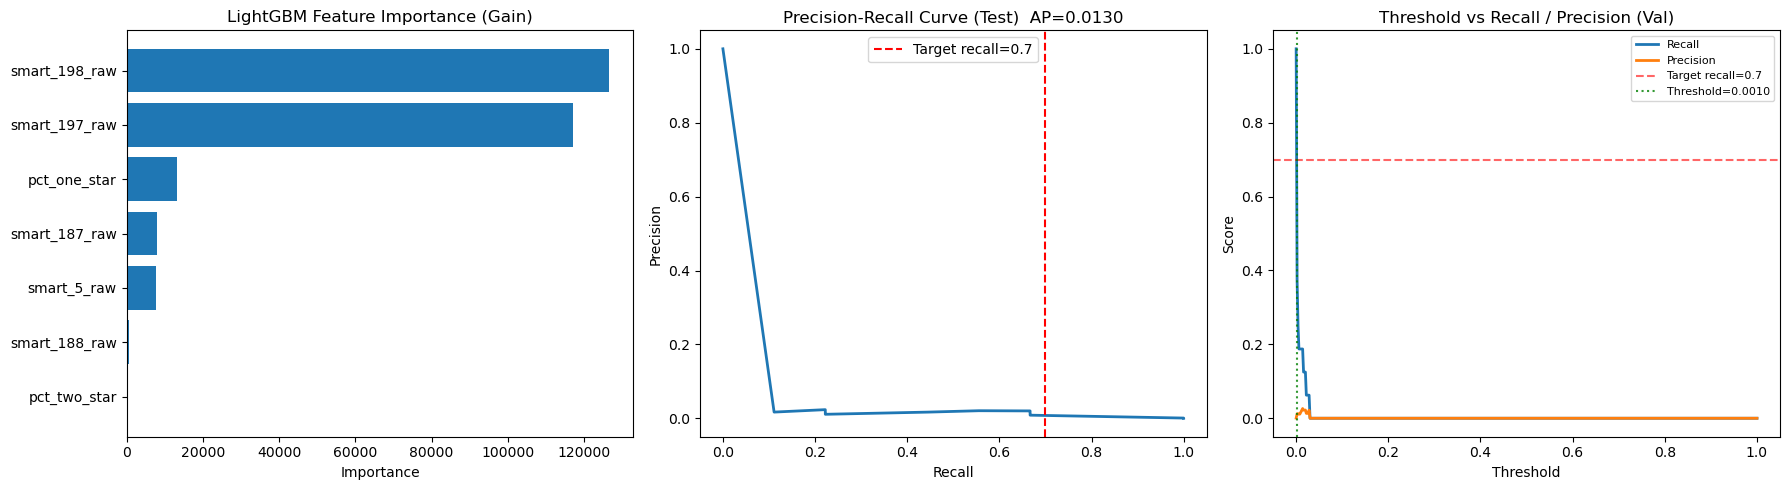


SUMMARY
  Decision threshold:    0.001038
  LightGBM best iter:   5
  scale_pos_weight:      54.5
  Target recall:         0.7


In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# LIGHTGBM MODEL TRAINING
# ══════════════════════════════════════════════════════════════════════════════

import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score,
    precision_score, f1_score, roc_auc_score, precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt

# ── 1. Feature and Target Setup ─────────────────────────────────────────────
# Select all 7 features: 5 SMART attributes + 2 review sentiment features
# This is the full feature set (unlike baseline which uses only SMART)
feature_cols = ['pct_one_star', 'pct_two_star', 'smart_5_raw',
                'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

# Prepare feature matrices (X) and target vectors (y) for each split
X_train = df_train[feature_cols].copy()
y_train = df_train['failure'].astype(int).copy()
X_val   = df_val[feature_cols].copy()
y_val   = df_val['failure'].astype(int).copy()
X_test  = df_test[feature_cols].copy()
y_test  = df_test['failure'].astype(int).copy()

# ── 2. Handle Class Imbalance ───────────────────────────────────────────────
# Calculate class counts to address severe imbalance (~0.04% failure rate)
n_neg = (y_train == 0).sum()  # Count of non-failures
n_pos = (y_train == 1).sum()  # Count of failures

# Use sqrt-dampened weighting instead of full ratio to avoid over-weighting
# Full ratio would be n_neg/n_pos ≈ 2500, but sqrt dampens it to ~50
scale_pos = np.sqrt(n_neg / n_pos)
print(f"Training positives: {n_pos}  negatives: {n_neg}")
print(f"scale_pos_weight (sqrt-dampened): {scale_pos:.1f}")

# ── 3. Create LightGBM Datasets ─────────────────────────────────────────────
# Convert pandas DataFrames to LightGBM Dataset format for efficient training
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)

# ── 4. Configure Model Parameters ───────────────────────────────────────────
params = {
    # Task configuration
    'objective':         'binary',         # Binary classification (failure vs no failure)
    'metric':            'auc',            # Optimize for AUC; used for early stopping
    'boosting_type':     'gbdt',           # Gradient Boosting Decision Tree
    
    # Class imbalance handling
    'scale_pos_weight':  scale_pos,        # Up-weight positive class (failures)
    
    # Learning parameters
    'learning_rate':     0.01,             # Small step size for gradual learning
    'num_leaves':        15,               # Max leaves per tree (controls complexity)
    'max_depth':         4,                # Max tree depth (prevents overfitting)
    
    # Regularization - minimum samples/weight to create a leaf
    'min_child_samples': 10,               # Min data points required in a leaf
    'min_child_weight':  1e-3,             # Min sum of instance weights in a leaf
    
    # Stochastic parameters (introduce randomness to prevent overfitting)
    'subsample':         0.7,              # Use 70% of data for each tree
    'colsample_bytree':  0.7,              # Use 70% of features for each tree
    
    # L1/L2 regularization
    'reg_alpha':         1.0,              # L1 regularization (feature sparsity)
    'reg_lambda':        5.0,              # L2 regularization (weight decay)
    
    # Data processing
    'max_bin':           127,              # Max bins for bucketing continuous features
    
    # Training control
    'verbose':           -1,               # Suppress LightGBM warnings
    'seed':              42,               # Random seed for reproducibility
    'force_row_wise':    True,             # Force row-wise histogram construction
}

# ── 5. Set Training Callbacks ───────────────────────────────────────────────
callbacks = [
    lgb.early_stopping(stopping_rounds=300),  # Stop if no AUC improvement for 300 rounds
    lgb.log_evaluation(period=200),           # Print progress every 200 rounds
]

# ── 6. Train the Model ──────────────────────────────────────────────────────
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=3000,      # Max boosting rounds (early stopping may stop sooner)
    valid_sets=[lgb_val],      # Validation set for early stopping
    valid_names=['val'],       # Name for validation metrics
    callbacks=callbacks,
)

# Print training summary
print(f"\nBest iteration: {model.best_iteration}")
print(f"Best val AUC:   {model.best_score['val']['auc']:.4f}")

# ── 7. Threshold Tuning (Target: ≥70% Recall with Minimal False Positives) ──
# Instead of using default 0.5 threshold, tune threshold on validation set
# Goal: Achieve at least 70% recall while minimizing false positives

# Generate predicted probabilities on validation set
y_val_prob = model.predict(X_val, num_iteration=model.best_iteration)

# Get precision-recall curve data (all possible thresholds)
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)

TARGET_RECALL = 0.70  # Minimum acceptable recall (catch 70% of failures)

# Evaluate all thresholds that meet the recall requirement
candidates = []
for p, r, t in zip(precisions[:-1], recalls[:-1], thresholds):
    if r >= TARGET_RECALL:  # Only consider thresholds meeting recall target
        # Calculate false positives for this threshold
        y_pred_tmp = (y_val_prob >= t).astype(int)
        fp_count = ((y_pred_tmp == 1) & (y_val == 0)).sum()
        candidates.append((p, r, t, fp_count))

# Select best threshold from candidates
if candidates:
    # Sort by: 1) fewest false positives (primary), 2) highest recall (tiebreaker)
    candidates.sort(key=lambda x: (x[3], -x[1]))
    best_prec, best_rec, best_thresh, best_fp = candidates[0]
    print(f"\nOptimal threshold on validation set: {best_thresh:.6f}")
    print(f"  -> Val Precision: {best_prec:.4f}   Val Recall: {best_rec:.4f}   Val FP: {best_fp}")
else:
    # Fallback: if target recall is unattainable, use closest threshold
    idx = np.argmin(np.abs(recalls[:-1] - TARGET_RECALL))
    best_thresh = thresholds[idx]
    best_rec = recalls[idx]
    best_prec = precisions[idx]
    print(f"\nCould not reach {TARGET_RECALL:.0%} recall; closest threshold: {best_thresh:.6f}")
    print(f"  -> Val Precision: {best_prec:.4f}   Val Recall: {best_rec:.4f}")

# ── 8. Evaluation Helper Function ───────────────────────────────────────────
def eval_set(name, y_true, y_prob, threshold):
    """
    Evaluate model predictions on a dataset using a custom threshold.
    
    Args:
        name: Dataset name (e.g., "VALIDATION", "TEST")
        y_true: True labels
        y_prob: Predicted probabilities
        threshold: Decision threshold for converting probabilities to predictions
    
    Returns:
        Confusion matrix
    """
    # Convert probabilities to binary predictions using custom threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Print classification report
    print(f"\n{'='*80}")
    print(f"{name} RESULTS  (threshold={threshold:.6f})")
    print(f"{'='*80}")
    print(classification_report(y_true, y_pred, digits=4,
                                target_names=['No Failure', 'Failure']))
    
    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate and display key metrics
    tn, fp, fn, tp = cm.ravel()
    rec  = tp/(tp+fn) if (tp+fn) > 0 else float('nan')
    prec = tp/(tp+fp) if (tp+fp) > 0 else float('nan')
    fpr  = fp/(fp+tn) if (fp+tn) > 0 else float('nan')
    print(f"\n  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
    print(f"  Recall (positive):    {rec:.4f}")
    print(f"  Precision (positive): {prec:.4f}")
    print(f"  False-positive rate:  {fpr:.6f}  ({fp:,} false positives)")
    
    # Calculate probability-based metrics (ROC-AUC, Average Precision)
    try:
        auc = roc_auc_score(y_true, y_prob)
        ap  = average_precision_score(y_true, y_prob)
        print(f"  ROC-AUC: {auc:.4f}   Average Precision: {ap:.4f}")
    except Exception:
        pass
    
    return cm

# ── 9. Evaluate on Validation and Test Sets ────────────────────────────────
# Evaluate on validation set (used for threshold tuning)
cm_val  = eval_set("VALIDATION",  y_val,  y_val_prob,  best_thresh)

# Evaluate on test set (final performance assessment)
y_test_prob = model.predict(X_test, num_iteration=model.best_iteration)
cm_test = eval_set("TEST", y_test, y_test_prob, best_thresh)

# ── 10. Visualizations ──────────────────────────────────────────────────────
# Create three-panel visualization for model analysis

# Panel 1: Feature Importance
importance = model.feature_importance(importance_type='gain')
feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importance})
feat_imp = feat_imp.sort_values('importance', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Feature importance (which features drive predictions)
axes[0].barh(feat_imp['feature'], feat_imp['importance'])
axes[0].set_title('LightGBM Feature Importance (Gain)')
axes[0].set_xlabel('Importance')

# Plot 2: Precision-Recall Curve on test set
prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)
ap_test = average_precision_score(y_test, y_test_prob)
axes[1].plot(rec_t, prec_t, lw=2)
axes[1].axvline(x=TARGET_RECALL, color='r', linestyle='--', label=f'Target recall={TARGET_RECALL}')
axes[1].set_title(f'Precision-Recall Curve (Test)  AP={ap_test:.4f}')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].legend()

# Plot 3: Threshold sensitivity analysis on validation set
# Shows how recall and precision change as threshold varies
thresholds_plot = np.linspace(0, 1, 500)
rec_plot  = [recall_score(y_val, (y_val_prob >= t).astype(int), zero_division=0) for t in thresholds_plot]
prec_plot = [precision_score(y_val, (y_val_prob >= t).astype(int), zero_division=0) for t in thresholds_plot]
axes[2].plot(thresholds_plot, rec_plot, label='Recall', lw=2)
axes[2].plot(thresholds_plot, prec_plot, label='Precision', lw=2)
axes[2].axhline(y=TARGET_RECALL, color='r', linestyle='--', alpha=0.6, label=f'Target recall={TARGET_RECALL}')
axes[2].axvline(x=best_thresh, color='green', linestyle=':', alpha=0.8, label=f'Threshold={best_thresh:.4f}')
axes[2].set_title('Threshold vs Recall / Precision (Val)')
axes[2].set_xlabel('Threshold'); axes[2].set_ylabel('Score')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

# ── 11. Training Summary ────────────────────────────────────────────────────
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"  Decision threshold:    {best_thresh:.6f}")
print(f"  LightGBM best iter:   {model.best_iteration}")
print(f"  scale_pos_weight:      {scale_pos:.1f}")
print(f"  Target recall:         {TARGET_RECALL}")

## 12. Model Comparison — Confusion Matrices & Metrics

Side-by-side confusion matrix plots and a summary table comparing Baseline LR vs LightGBM across validation and test splits. Metrics include recall, precision, false-positive rate, ROC-AUC, and average precision.

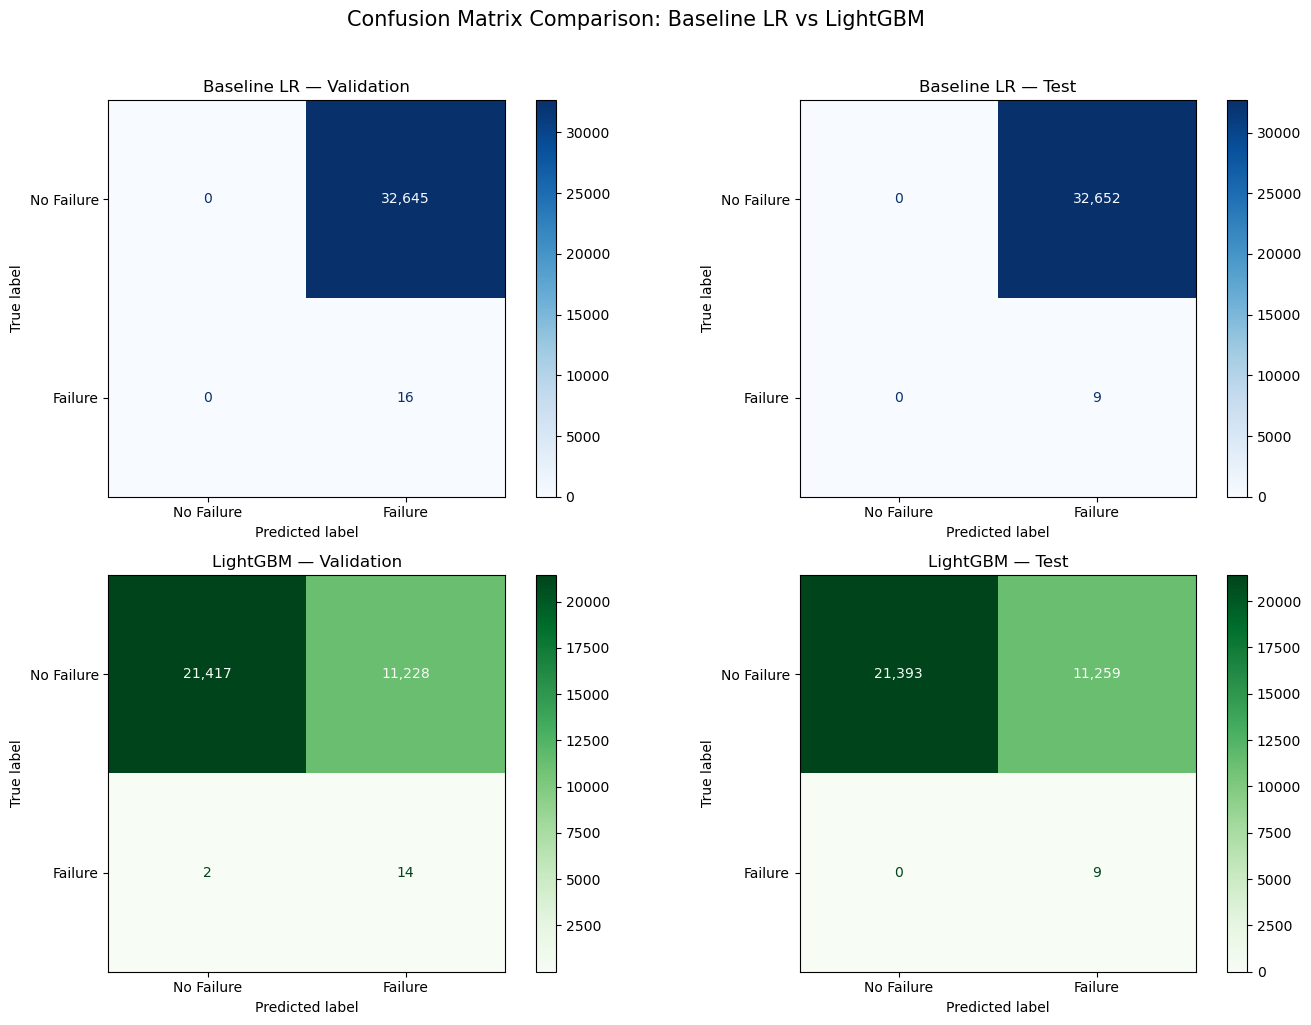

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ── Side-by-side Confusion Matrix Comparison ────────────────────────────────
datasets_compare = {
    'Validation': (cm_val_bl, cm_val),
    'Test':       (cm_test_bl, cm_test),
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
labels = ['No Failure', 'Failure']

for col, (split_name, (cm_bl, cm_lgb)) in enumerate(datasets_compare.items()):
    # Baseline (top row)
    disp_bl = ConfusionMatrixDisplay(confusion_matrix=cm_bl, display_labels=labels)
    disp_bl.plot(ax=axes[0, col], cmap='Blues', values_format=',')
    axes[0, col].set_title(f'Baseline LR — {split_name}', fontsize=12)

    # LightGBM (bottom row)
    disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=labels)
    disp_lgb.plot(ax=axes[1, col], cmap='Greens', values_format=',')
    axes[1, col].set_title(f'LightGBM — {split_name}', fontsize=12)

plt.suptitle('Confusion Matrix Comparison: Baseline LR vs LightGBM', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## 13. Deploy LightGBM Model to SageMaker Endpoint

Package the trained LightGBM model, upload to S3, and deploy as a real-time inference endpoint. The endpoint name and configuration are saved to `.env` for later use.

In [12]:
# ══════════════════════════════════════════════════════════════════════════════
# SAGEMAKER ENDPOINT DEPLOYMENT
# ══════════════════════════════════════════════════════════════════════════════

import json
import tarfile
import time
from datetime import datetime
from sagemaker.model_monitor import DataCaptureConfig

# ── 1. Save Trained Model ───────────────────────────────────────────────────
# Save LightGBM model in native format
model_file = 'lgb_model.txt'
model.save_model(model_file)
print(f"✓ Model saved to {model_file}")

# Save model metadata (threshold, feature names, etc.)
model_metadata = {
    'threshold': float(best_thresh),
    'target_recall': TARGET_RECALL,
    'feature_cols': feature_cols,
    'best_iteration': model.best_iteration,
    'scale_pos_weight': float(scale_pos),
    'trained_date': datetime.now().isoformat()
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ Metadata saved to model_metadata.json")

# ── 2. Create Inference Script ──────────────────────────────────────────────
# SageMaker SKLearn container compatible inference script
inference_script = '''import json
import os
import io
import numpy as np
import lightgbm as lgb

def model_fn(model_dir):
    """
    Load the LightGBM model from the model directory.
    This function is called by SageMaker when the endpoint starts.
    """
    model_file = os.path.join(model_dir, 'lgb_model.txt')
    metadata_file = os.path.join(model_dir, 'model_metadata.json')
    
    model = lgb.Booster(model_file=model_file)
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    return {'model': model, 'metadata': metadata}

def input_fn(input_data, content_type='application/json'):
    """
    Deserialize input data. Handles JSON and numpy formats.
    """
    if content_type == 'application/json':
        data = json.loads(input_data)
        # Handle both direct list and dict with 'features' key
        if isinstance(data, dict) and 'features' in data:
            return np.array(data['features'])
        return np.array(data)
    elif content_type == 'application/x-npy':
        # Handle numpy binary format (default SKLearn serializer)
        return np.load(io.BytesIO(input_data), allow_pickle=False)
    raise ValueError(f'Unsupported content type: {content_type}')

def predict_fn(input_data, model_dict):
    """
    Run prediction on input data.
    """
    model = model_dict['model']
    metadata = model_dict['metadata']
    threshold = metadata['threshold']
    
    # Ensure input is numpy array
    if not isinstance(input_data, np.ndarray):
        input_data = np.array(input_data)
    
    # Reshape if needed (single sample)
    if input_data.ndim == 1:
        input_data = input_data.reshape(1, -1)
    
    # Get predictions
    probabilities = model.predict(input_data)
    predictions = (probabilities >= threshold).astype(int)
    
    return {
        'predictions': predictions.tolist(),
        'probabilities': probabilities.tolist(),
        'threshold': threshold,
        'feature_names': metadata.get('feature_cols', [])
    }

def output_fn(prediction, accept='application/json'):
    """
    Serialize prediction output.
    """
    return json.dumps(prediction), 'application/json'
'''

with open('inference.py', 'w') as f:
    f.write(inference_script)
print(f"✓ Inference script created: inference.py")

# Create requirements.txt for dependencies
requirements_txt = '''lightgbm==3.3.5
numpy
scikit-learn
'''
with open('requirements.txt', 'w') as f:
    f.write(requirements_txt)
print(f"✓ Requirements file created: requirements.txt")

# ── 3. Package Model as tar.gz ──────────────────────────────────────────────
# SageMaker expects model artifacts in a compressed tar.gz file
# NOTE: Don't include inference.py in tar.gz; it's provided separately
model_archive = 'model.tar.gz'
with tarfile.open(model_archive, 'w:gz') as tar:
    tar.add(model_file)
    tar.add('model_metadata.json')

print(f"✓ Model packaged: {model_archive}")

# ── 4. Upload Model to S3 ───────────────────────────────────────────────────
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
model_s3_key = f"models/lgb-hdd-failure/{timestamp}/model.tar.gz"
model_s3_uri = f"s3://{bucket}/{model_s3_key}"

s3_client.upload_file(model_archive, bucket, model_s3_key)
print(f"✓ Model uploaded to: {model_s3_uri}")

# ── 5. Create SageMaker Model ───────────────────────────────────────────────
from sagemaker.sklearn import SKLearnModel

# Use SKLearn container which supports LightGBM
# SageMaker doesn't have a dedicated LightGBM container, but SKLearn works
model_name = f"lgb-hdd-failure-{timestamp}"

# Create model using SageMaker Python SDK (handles container image automatically)
sklearn_model = SKLearnModel(
    model_data=model_s3_uri,
    role=role,
    entry_point='inference.py',
    framework_version='1.2-1',  # SKLearn version
    py_version='py3',
    name=model_name,
    sagemaker_session=sagemaker_session,
    dependencies=['requirements.txt']  # Install LightGBM dependency
)

print(f"✓ SageMaker model created: {model_name}")

# ── 6. Configure Data Capture for Model Monitor ─────────────────────────────
# Data Capture records inference requests/responses to S3.
# Required for SageMaker Model Monitor to detect data drift and quality issues.
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/monitoring/data-capture/{model_name}",
    capture_options=["Input", "Output"],
    csv_content_types=["text/csv"],
    json_content_types=["application/json"],
)
print(f"✓ Data Capture configured (100% sampling → s3://{bucket}/monitoring/data-capture/{model_name})")

# ── 7. Deploy Endpoint ──────────────────────────────────────────────────────
endpoint_name = f"lgb-hdd-failure-endpoint-{timestamp}"

print(f"\n{'='*80}")
print(f"ENDPOINT DEPLOYMENT INITIATED")
print(f"{'='*80}")
print(f"  Endpoint Name: {endpoint_name}")
print(f"  Data Capture:  Enabled (100% sampling)")
print(f"  Status: Creating...")
print(f"\n  This will take 5-10 minutes. Deploying endpoint...")

# Deploy using SageMaker SDK (handles endpoint config automatically)
try:
    predictor = sklearn_model.deploy(
        initial_instance_count=1,
        instance_type='ml.m5.large',
        endpoint_name=endpoint_name,
        data_capture_config=data_capture_config,
        wait=True  # Wait for endpoint to be InService
    )
    print(f"\n✓ Endpoint is InService and ready for predictions!")
    endpoint_config_name = f"{endpoint_name}-config"
except Exception as e:
    print(f"\n⚠ Error during deployment: {e}")
    print(f"  Check endpoint status in SageMaker console")
    raise

# ── 8. Update .env File ─────────────────────────────────────────────────────
# Append endpoint information to .env file
env_updates = f"""
# LightGBM Model Endpoint (deployed {datetime.now().strftime('%Y-%m-%d %H:%M:%S')})
ENDPOINT_NAME='{endpoint_name}'
MODEL_NAME='{model_name}'
ENDPOINT_CONFIG_NAME='{endpoint_config_name}'
MODEL_S3_URI='{model_s3_uri}'
MODEL_THRESHOLD={best_thresh:.6f}
"""

with open('.env', 'a') as f:
    f.write(env_updates)

print(f"\n{'='*80}")
print(f"DEPLOYMENT COMPLETE")
print(f"{'='*80}")
print(f"✓ .env file updated with endpoint details")
print(f"\nEndpoint details:")
print(f"  Name: {endpoint_name}")
print(f"  Model: {model_name}")
print(f"  Instance: ml.m5.large")
print(f"  Threshold: {best_thresh:.6f}")
print(f"  Data Capture: Enabled (100% sampling)")
print(f"  S3 URI: {model_s3_uri}")

print(f"{'='*80}")

# ── 9. Test the Endpoint ────────────────────────────────────────────────────print(f"TESTING ENDPOINT")
print(f"\n{'='*80}")

✓ Model saved to lgb_model.txt
✓ Metadata saved to model_metadata.json
✓ Inference script created: inference.py
✓ Requirements file created: requirements.txt
✓ Model packaged: model.tar.gz
✓ Model uploaded to: s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/model.tar.gz
✓ SageMaker model created: lgb-hdd-failure-20260215-185627
✓ Data Capture configured (100% sampling → s3://mlops-backblaze-4263963c-us-east-1/monitoring/data-capture/lgb-hdd-failure-20260215-185627)

ENDPOINT DEPLOYMENT INITIATED
  Endpoint Name: lgb-hdd-failure-endpoint-20260215-185627
  Data Capture:  Enabled (100% sampling)
  Status: Creating...

  This will take 5-10 minutes. Deploying endpoint...
------!
✓ Endpoint is InService and ready for predictions!

DEPLOYMENT COMPLETE
✓ .env file updated with endpoint details

Endpoint details:
  Name: lgb-hdd-failure-endpoint-20260215-185627
  Model: lgb-hdd-failure-20260215-185627
  Instance: ml.m5.large
  Threshold: 0.001038
  Data Capture: 

In [13]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Set JSON serializer/deserializer (default is numpy which sends application/x-npy)
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

try:
    # Use first test sample
    test_sample = X_test.iloc[0:1].values.tolist()
    
    # Send JSON payload to the endpoint
    response = predictor.predict({'features': test_sample})
    
    result = response if isinstance(response, dict) else json.loads(response)
    print(f"Sample prediction:")
    print(f"  Input features: {test_sample[0]}")
    print(f"  Prediction: {result['predictions'][0]} ({'Failure' if result['predictions'][0] == 1 else 'No Failure'})")
    print(f"  Probability: {result['probabilities'][0]:.4f}")
    print(f"  Threshold: {result['threshold']:.6f}")
    print(f"\n✓ Endpoint is working correctly!")
    
except Exception as e:
    print(f"\n⚠ Warning: Endpoint test failed with error:")
    print(f"  {str(e)[:200]}")
    print(f"\nTroubleshooting steps:")
    print(f"  1. Check CloudWatch Logs for the endpoint:")
    print(f"     https://console.aws.amazon.com/cloudwatch/")
    print(f"  2. Verify LightGBM is installed in the container")
    print(f"  3. Test with direct boto3 invoke_endpoint call")
    print(f"\n  The endpoint is deployed but may need debugging.")
    print(f"  You can delete it to avoid charges: predictor.delete_endpoint()")
    print(f"\n  Endpoint Name: {endpoint_name}")
    print(f"  Model artifacts are saved in S3: {model_s3_uri}")

Sample prediction:
  Input features: [25.12, 7.27, 0.0, 0.0, 0.0, 0.0, 0.0]
  Prediction: 0 (No Failure)
  Probability: 0.0005
  Threshold: 0.001038

✓ Endpoint is working correctly!


## 14. Register Model in SageMaker Model Registry

Create a **Model Package Group** and register the trained LightGBM model as a versioned **Model Package** with evaluation metrics. This enables:
- **Version control**: Track model iterations with approval status
- **CI/CD integration**: Pipeline can query the registry for approved models
- **Metric tracking**: Evaluation results stored alongside the model artifact

In [14]:
# ══════════════════════════════════════════════════════════════════════════════
# MODEL REGISTRY — Register trained model for CI/CD pipeline
# ══════════════════════════════════════════════════════════════════════════════

import json
from datetime import datetime
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, accuracy_score
)

sm_client = boto3.client('sagemaker', region_name=region)

# ── 1. Create Model Package Group ───────────────────────────────────────────
model_package_group_name = "hdd-failure-prediction"

try:
    sm_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription=(
            "LightGBM models for hard drive failure prediction using "
            "SMART attributes and review-sentiment features."
        )
    )
    print(f"✓ Created Model Package Group: {model_package_group_name}")
except sm_client.exceptions.ClientError as e:
    if 'already exists' in str(e).lower() or 'ValidationException' in str(e):
        print(f"ℹ Model Package Group already exists: {model_package_group_name}")
    else:
        raise

# ── 2. Compute evaluation metrics on test set ───────────────────────────────
y_test_pred = (y_test_prob >= best_thresh).astype(int)

eval_metrics = {
    "roc_auc":            float(roc_auc_score(y_test, y_test_prob)),
    "average_precision":  float(average_precision_score(y_test, y_test_prob)),
    "recall":             float(recall_score(y_test, y_test_pred)),
    "precision":          float(precision_score(y_test, y_test_pred, zero_division=0)),
    "f1":                 float(f1_score(y_test, y_test_pred, zero_division=0)),
    "accuracy":           float(accuracy_score(y_test, y_test_pred)),
    "threshold":          float(best_thresh),
    "best_iteration":     int(model.best_iteration),
    "scale_pos_weight":   float(scale_pos),
    "n_features":         len(feature_cols),
    "train_samples":      int(len(X_train)),
    "test_samples":       int(len(X_test)),
}

print("\nTest-set evaluation metrics:")
for k, v in eval_metrics.items():
    print(f"  {k:22s}: {v}")

# Save metrics JSON to S3 for Model Registry
metrics_report = {
    "binary_classification_metrics": {
        "auc":               {"value": eval_metrics["roc_auc"],           "standard_deviation": "NaN"},
        "recall":            {"value": eval_metrics["recall"],            "standard_deviation": "NaN"},
        "precision":         {"value": eval_metrics["precision"],         "standard_deviation": "NaN"},
        "f1":                {"value": eval_metrics["f1"],                "standard_deviation": "NaN"},
        "accuracy":          {"value": eval_metrics["accuracy"],          "standard_deviation": "NaN"},
        "average_precision":  {"value": eval_metrics["average_precision"], "standard_deviation": "NaN"},
    }
}

metrics_s3_key = f"models/lgb-hdd-failure/{timestamp}/evaluation_metrics.json"
s3_client.put_object(
    Bucket=bucket,
    Key=metrics_s3_key,
    Body=json.dumps(metrics_report, indent=2),
    ContentType="application/json"
)
metrics_s3_uri = f"s3://{bucket}/{metrics_s3_key}"
print(f"\n✓ Evaluation metrics uploaded to: {metrics_s3_uri}")

# ── 3. Get container image URI ───────────────────────────────────────────────
from sagemaker import image_uris

sklearn_image_uri = image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="1.2-1",
    py_version="py3",
    instance_type="ml.m5.large",
    image_scope="inference",
)
print(f"  Container image: {sklearn_image_uri}")

# ── 4. Register model as a Model Package ─────────────────────────────────────
model_package_input = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageDescription": (
        f"LightGBM v{model.best_iteration} — threshold={best_thresh:.6f}, "
        f"test AUC={eval_metrics['roc_auc']:.4f}, recall={eval_metrics['recall']:.4f}"
    ),
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": sklearn_image_uri,
                "ModelDataUrl": model_s3_uri,
            }
        ],
        "SupportedContentTypes": ["application/json"],
        "SupportedResponseMIMETypes": ["application/json"],
        "SupportedTransformInstanceTypes": ["ml.m5.large"],
        "SupportedRealtimeInferenceInstanceTypes": ["ml.m5.large", "ml.m5.xlarge"],
    },
    "ModelMetrics": {
        "ModelQuality": {
            "Statistics": {
                "ContentType": "application/json",
                "S3Uri": metrics_s3_uri,
            }
        }
    },
    "ModelApprovalStatus": "PendingManualApproval",
    "CustomerMetadataProperties": {
        "threshold":        str(best_thresh),
        "target_recall":    str(TARGET_RECALL),
        "feature_columns":  " ".join(feature_cols),
        "framework":        "lightgbm",
    },
}

response = sm_client.create_model_package(**model_package_input)
model_package_arn = response["ModelPackageArn"]
print(f"\n✓ Model registered: {model_package_arn}")
print(f"  Approval status: PendingManualApproval")

# ── 5. Approve the model (simulate CI gate) ─────────────────────────────────
sm_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved",
    ApprovalDescription="Auto-approved — meets recall target on test set."
)
print(f"✓ Model approved in registry")

# ── 6. Save to .env ─────────────────────────────────────────────────────────
from dotenv import set_key

set_key(ENV_PATH, "MODEL_PACKAGE_GROUP", model_package_group_name)
set_key(ENV_PATH, "MODEL_PACKAGE_ARN", model_package_arn)
set_key(ENV_PATH, "EVALUATION_METRICS_S3", metrics_s3_uri)

print(f"\n{'='*80}")
print("MODEL REGISTRY SUMMARY")
print(f"{'='*80}")
print(f"  Package Group:  {model_package_group_name}")
print(f"  Package ARN:    {model_package_arn}")
print(f"  Metrics S3:     {metrics_s3_uri}")
print(f"  Model S3:       {model_s3_uri}")
print(f"  Status:         Approved")
print(f"{'='*80}")

ℹ Model Package Group already exists: hdd-failure-prediction

Test-set evaluation metrics:
  roc_auc               : 0.9355543985735093
  average_precision     : 0.013047265546175588
  recall                : 1.0
  precision             : 0.0007987220447284345
  f1                    : 0.0015961691939345571
  accuracy              : 0.6552769357949848
  threshold             : 0.0010379018278007226
  best_iteration        : 5
  scale_pos_weight      : 54.48102255080954
  n_features            : 7
  train_samples         : 130644
  test_samples          : 32661

✓ Evaluation metrics uploaded to: s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/evaluation_metrics.json
  Container image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3

✓ Model registered: arn:aws:sagemaker:us-east-1:173448391640:model-package/hdd-failure-prediction/3
  Approval status: PendingManualApproval
✓ Model approved in registry

MODEL REGISTRY SUMMARY

## 15. Create SageMaker Model Card

Generate a **Model Card** documenting the model's intended use, training details, evaluation results, and ethical considerations. Model Cards provide governance and transparency required for production ML systems.

In [15]:
# ══════════════════════════════════════════════════════════════════════════════
# MODEL CARD — Document model for governance and transparency
# ══════════════════════════════════════════════════════════════════════════════

from sagemaker.model_card import (
    ModelCard,
    ModelOverview,
    IntendedUses,
    BusinessDetails,
    ObjectiveFunction,
    Function,
    TrainingDetails,
    TrainingJobDetails,
    EvaluationJob,
    MetricGroup,
    Metric,
    MetricTypeEnum,
    ModelCardStatusEnum,
    AdditionalInformation,
)

model_card_name = f"hdd-failure-lgb-{timestamp}"

# ── 1. Model Overview ───────────────────────────────────────────────────────
model_overview = ModelOverview(
    model_description=(
        "LightGBM gradient boosting classifier for predicting hard drive failures "
        "using five SMART health metrics and two manufacturer review-sentiment "
        "features. Trained on Backblaze open-source drive statistics joined with "
        "Amazon product review data."
    ),
    model_creator="AAI-540 Group 9",
    model_artifact=[model_s3_uri],
    algorithm_type="LightGBM (Gradient Boosting Decision Tree)",
    problem_type="Binary Classification",
)

# ── 2. Intended Uses ────────────────────────────────────────────────────────
intended_uses = IntendedUses(
    purpose_of_model=(
        "Predict imminent hard drive failure so that datacenter operators can "
        "proactively replace drives before data loss occurs."
    ),
    intended_uses=(
        "Real-time inference on daily SMART telemetry collected from drives in "
        "production datacenters. A failure probability above the tuned threshold "
        f"({best_thresh:.6f}) triggers a replacement alert."
    ),
    factors_affecting_model_efficiency=(
        "Model performance depends on the availability and accuracy of SMART "
        "sensor data. Drives from manufacturers not present in the training data "
        "may yield degraded predictions. Extreme class imbalance (~0.04 % failure "
        "rate) means false-positive rates must be carefully monitored."
    ),
    risk_rating="Medium",
    explanations_for_risk_rating=(
        "False negatives risk data loss; false positives waste replacement hardware. "
        "Neither outcome is safety-critical but both have material cost impact."
    ),
)

# ── 3. Training Details ─────────────────────────────────────────────────────
training_details = TrainingDetails(
    objective_function=ObjectiveFunction(
        function=Function(function="Minimize", facet="Loss", condition="Binary Cross-Entropy"),
        notes=(
            f"Optimized with scale_pos_weight={scale_pos:.1f} (sqrt-dampened) to "
            "address severe class imbalance. Early stopping on validation AUC "
            f"selected iteration {model.best_iteration} of 3000 max rounds."
        ),
    ),
    training_observations=(
        f"Training set: {len(X_train):,} samples ({y_train.sum()} failures). "
        f"Validation set: {len(X_val):,} samples. "
        f"Test set: {len(X_test):,} samples. "
        f"Best validation AUC: {model.best_score['val']['auc']:.4f}. "
        f"Decision threshold tuned on validation set for ≥{TARGET_RECALL:.0%} recall."
    ),
)

# ── 4. Evaluation Metrics ───────────────────────────────────────────────────
test_metrics = MetricGroup(
    name="Test Set Evaluation",
    metric_data=[
        Metric(name="ROC-AUC",           type=MetricTypeEnum.NUMBER, value=eval_metrics["roc_auc"]),
        Metric(name="Average Precision",  type=MetricTypeEnum.NUMBER, value=eval_metrics["average_precision"]),
        Metric(name="Recall",            type=MetricTypeEnum.NUMBER, value=eval_metrics["recall"]),
        Metric(name="Precision",         type=MetricTypeEnum.NUMBER, value=eval_metrics["precision"]),
        Metric(name="F1 Score",          type=MetricTypeEnum.NUMBER, value=eval_metrics["f1"]),
        Metric(name="Accuracy",          type=MetricTypeEnum.NUMBER, value=eval_metrics["accuracy"]),
        Metric(name="Decision Threshold", type=MetricTypeEnum.NUMBER, value=eval_metrics["threshold"]),
    ],
)

eval_details = [
    EvaluationJob(
        name="LightGBM Test Evaluation",
        evaluation_observation=(
            f"Model achieves {eval_metrics['recall']:.2%} recall at "
            f"{eval_metrics['precision']:.2%} precision on the held-out test set "
            f"(AUC={eval_metrics['roc_auc']:.4f}). "
            "False-positive rate should be monitored in production."
        ),
        metric_groups=[test_metrics],
        datasets=[f"s3://{bucket}/feature-store/"],
    )
]

# ── 5. Additional Information ───────────────────────────────────────────────
additional_info = AdditionalInformation(
    ethical_considerations=(
        "This model predicts hardware failure only; it does not make decisions "
        "about people. Predictions should be treated as advisory signals reviewed "
        "by datacenter operations staff before taking action."
    ),
    custom_details={
        "feature_columns": ", ".join(feature_cols),
        "model_package_arn": model_package_arn,
        "data_source": "Backblaze Open-Source Drive Statistics + Amazon Reviews",
    },
)

# ── 6. Create the Model Card ────────────────────────────────────────────────
try:
    model_card = ModelCard(
        name=model_card_name,
        status=ModelCardStatusEnum.DRAFT,
        model_overview=model_overview,
        intended_uses=intended_uses,
        training_details=training_details,
        evaluation_details=eval_details,
        additional_information=additional_info,
        sagemaker_session=sagemaker_session,
    )
    model_card.create()
    model_card_arn = model_card.arn

    print(f"✓ Model Card created: {model_card_name}")
    print(f"  ARN: {model_card_arn}")
    print(f"  Status: Draft")
    
    # Save to .env
    set_key(ENV_PATH, "MODEL_CARD_NAME", model_card_name)
    set_key(ENV_PATH, "MODEL_CARD_ARN", model_card_arn)

except Exception as e:
    print(f"⚠ Model Card creation failed: {e}")
    print("  This is non-blocking — model registry is still valid.")
    model_card_arn = "N/A"

print(f"\n{'='*80}")
print("MODEL CARD SUMMARY")
print(f"{'='*80}")
print(f"  Name:   {model_card_name}")
print(f"  ARN:    {model_card_arn}")
print(f"  Status: Draft (update to 'Active' after review)")
print(f"{'='*80}")

✓ Model Card created: hdd-failure-lgb-20260215-185627
  ARN: arn:aws:sagemaker:us-east-1:173448391640:model-card/hdd-failure-lgb-20260215-185627
  Status: Draft

MODEL CARD SUMMARY
  Name:   hdd-failure-lgb-20260215-185627
  ARN:    arn:aws:sagemaker:us-east-1:173448391640:model-card/hdd-failure-lgb-20260215-185627
  Status: Draft (update to 'Active' after review)


## 16. Generate Baselines for Model Monitor

Create **data quality** and **model quality** baselines from the training and test sets. These baselines are used by SageMaker Model Monitor to detect:
- **Data drift**: Feature distributions shifting from training data
- **Model quality degradation**: Metrics falling below acceptable thresholds

**Monitoring criteria** (aligned with threshold tuning strategy):
1. **Hard constraint**: Recall on the positive (failure) class must remain **≥ 70 %**
2. **Soft optimisation**: Once recall is met, minimize false positives (tracked via precision floor and FP count)
3. **Data quality gates**: Feature null rates and distribution drift are bounded

Baselines are uploaded to S3 so the CI/CD monitoring notebook can reference them.

In [16]:
# ══════════════════════════════════════════════════════════════════════════════
# BASELINES FOR MODEL MONITOR
# ══════════════════════════════════════════════════════════════════════════════

import numpy as np

baseline_prefix = f"models/lgb-hdd-failure/{timestamp}/baselines"

# ── 1. Data Quality Baseline ────────────────────────────────────────────────
# Compute feature-level statistics from training data that Model Monitor will
# compare against incoming production data to detect feature drift.

print("="*80)
print("GENERATING DATA QUALITY BASELINE")
print("="*80)

data_stats = {}
for col in feature_cols:
    values = X_train[col].dropna()
    data_stats[col] = {
        "mean":   float(values.mean()),
        "std":    float(values.std()),
        "min":    float(values.min()),
        "max":    float(values.max()),
        "median": float(values.median()),
        "q1":     float(values.quantile(0.25)),
        "q3":     float(values.quantile(0.75)),
        "null_pct": float(X_train[col].isna().mean() * 100),
        "count":  int(len(values)),
    }
    print(f"  {col:22s}  mean={data_stats[col]['mean']:.4f}  "
          f"std={data_stats[col]['std']:.4f}  "
          f"[{data_stats[col]['min']:.0f}, {data_stats[col]['max']:.0f}]")

# Save as JSON
data_quality_s3_key = f"{baseline_prefix}/data_quality_baseline.json"
s3_client.put_object(
    Bucket=bucket,
    Key=data_quality_s3_key,
    Body=json.dumps(data_stats, indent=2),
    ContentType="application/json",
)
data_quality_s3_uri = f"s3://{bucket}/{data_quality_s3_key}"
print(f"\n✓ Data quality baseline → {data_quality_s3_uri}")

# Also save training data as CSV (header-only for schema + full for baselining)
# SageMaker DefaultModelMonitor.suggest_baseline() expects a CSV dataset
baseline_csv_key = f"{baseline_prefix}/training_data_baseline.csv"
csv_buffer = X_train.copy()
csv_buffer["failure"] = y_train.values
csv_body = csv_buffer.to_csv(index=False)
s3_client.put_object(
    Bucket=bucket,
    Key=baseline_csv_key,
    Body=csv_body,
    ContentType="text/csv",
)
baseline_csv_s3_uri = f"s3://{bucket}/{baseline_csv_key}"
print(f"✓ Training CSV baseline → {baseline_csv_s3_uri}")

# ── 2. Model Quality Baseline ───────────────────────────────────────────────
# Store ground-truth + predictions on test set. Model Monitor compares
# new-endpoint predictions against this baseline to detect quality regression.

print(f"\n{'='*80}")
print("GENERATING MODEL QUALITY BASELINE")
print(f"{'='*80}")

y_test_pred_monitor = (y_test_prob >= best_thresh).astype(int)

model_quality_df = pd.DataFrame({
    "prediction":  y_test_pred_monitor,
    "probability": y_test_prob,
    "label":       y_test.values.astype(int),
})

# Compute baseline false-positive count for monitoring reference
baseline_fp = int(((y_test_pred_monitor == 1) & (y_test.values == 0)).sum())
baseline_fn = int(((y_test_pred_monitor == 0) & (y_test.values == 1)).sum())
baseline_tp = int(((y_test_pred_monitor == 1) & (y_test.values == 1)).sum())
baseline_tn = int(((y_test_pred_monitor == 0) & (y_test.values == 0)).sum())

print(f"  Test samples:        {len(model_quality_df):,}")
print(f"  Predicted failures:  {model_quality_df['prediction'].sum():,}")
print(f"  Actual failures:     {model_quality_df['label'].sum():,}")
print(f"  Threshold:           {best_thresh:.6f}")
print(f"  TP={baseline_tp}  FP={baseline_fp}  FN={baseline_fn}  TN={baseline_tn}")

model_quality_s3_key = f"{baseline_prefix}/model_quality_baseline.csv"
s3_client.put_object(
    Bucket=bucket,
    Key=model_quality_s3_key,
    Body=model_quality_df.to_csv(index=False),
    ContentType="text/csv",
)
model_quality_s3_uri = f"s3://{bucket}/{model_quality_s3_key}"
print(f"\n✓ Model quality baseline → {model_quality_s3_uri}")

# ── 3. Monitoring Constraints (Recall-First, Then Minimise FP) ──────────────
# These constraints encode the two-tier evaluation strategy:
#   HARD gate  → recall ≥ 0.70 (must pass or the model is rejected)
#   SOFT gates → precision, FP count, AUC (should not degrade significantly)

monitoring_constraints = {
    # ── Primary constraint: recall on positive class ≥ TARGET_RECALL ────────
    "primary_constraint": {
        "metric":      "recall",
        "operator":    ">=",
        "threshold":   TARGET_RECALL,     # 0.70
        "description": "Hard gate — model MUST achieve ≥70% recall on the failure class",
        "action":      "reject",          # CI/CD should block deployment if violated
    },
    # ── Secondary constraints: minimise FP once recall is met ───────────────
    "secondary_constraints": {
        "precision": {
            "min":       eval_metrics["precision"] * 0.80,  # allow up to 20% degradation
            "baseline":  eval_metrics["precision"],
            "action":    "warn",
            "description": "Precision should not drop more than 20% from baseline",
        },
        "false_positives": {
            "max":       int(baseline_fp * 1.25),           # allow up to 25% increase
            "baseline":  baseline_fp,
            "action":    "warn",
            "description": "FP count should not increase more than 25% from baseline",
        },
        "roc_auc": {
            "min":       eval_metrics["roc_auc"] * 0.95,    # allow up to 5% degradation
            "baseline":  eval_metrics["roc_auc"],
            "action":    "warn",
            "description": "ROC-AUC should not drop more than 5% from baseline",
        },
        "average_precision": {
            "min":       eval_metrics["average_precision"] * 0.90,
            "baseline":  eval_metrics["average_precision"],
            "action":    "warn",
            "description": "Average Precision should not drop more than 10% from baseline",
        },
    },
    # ── Data quality gates ──────────────────────────────────────────────────
    "data_quality": {
        "max_null_pct":      5.0,         # reject if any feature > 5% null
        "max_feature_drift": 0.2,         # Kolmogorov-Smirnov threshold
    },
    # ── Metadata ────────────────────────────────────────────────────────────
    "decision_threshold":    float(best_thresh),
    "target_recall":         float(TARGET_RECALL),
    "feature_cols":          feature_cols,
    "baseline_confusion":    {
        "tp": baseline_tp, "fp": baseline_fp,
        "fn": baseline_fn, "tn": baseline_tn,
    },
    "tuning_strategy": (
        "Ensure ≥70% recall on the positive (failure) class, "
        "then among qualifying thresholds select the one with the fewest false positives."
    ),
}

constraints_s3_key = f"{baseline_prefix}/monitoring_constraints.json"
s3_client.put_object(
    Bucket=bucket,
    Key=constraints_s3_key,
    Body=json.dumps(monitoring_constraints, indent=2),
    ContentType="application/json",
)
constraints_s3_uri = f"s3://{bucket}/{constraints_s3_key}"
print(f"✓ Monitoring constraints → {constraints_s3_uri}")

# Print constraint summary
print(f"\n{'='*80}")
print("MONITORING CONSTRAINT SUMMARY")
print(f"{'='*80}")
print(f"  PRIMARY (hard gate):")
print(f"    recall >= {TARGET_RECALL:.2f}  (action: reject)")
print(f"  SECONDARY (soft gates — warn if violated):")
print(f"    precision >= {eval_metrics['precision'] * 0.80:.4f}  (baseline: {eval_metrics['precision']:.4f})")
print(f"    FP count  <= {int(baseline_fp * 1.25)}  (baseline: {baseline_fp})")
print(f"    ROC-AUC   >= {eval_metrics['roc_auc'] * 0.95:.4f}  (baseline: {eval_metrics['roc_auc']:.4f})")
print(f"    Avg Prec  >= {eval_metrics['average_precision'] * 0.90:.4f}  (baseline: {eval_metrics['average_precision']:.4f})")
print(f"  DATA QUALITY:")
print(f"    max null %:       {5.0}")
print(f"    max KS drift:     {0.2}")

# ── 4. Save all baseline URIs to .env ────────────────────────────────────────
set_key(ENV_PATH, "BASELINE_DATA_QUALITY_S3", data_quality_s3_uri)
set_key(ENV_PATH, "BASELINE_TRAINING_CSV_S3", baseline_csv_s3_uri)
set_key(ENV_PATH, "BASELINE_MODEL_QUALITY_S3", model_quality_s3_uri)
set_key(ENV_PATH, "MONITORING_CONSTRAINTS_S3", constraints_s3_uri)
set_key(ENV_PATH, "BASELINE_PREFIX_S3", f"s3://{bucket}/{baseline_prefix}")
set_key(ENV_PATH, "TARGET_RECALL", str(TARGET_RECALL))

print(f"\n{'='*80}")
print("BASELINE GENERATION COMPLETE")
print(f"{'='*80}")
print(f"  Data Quality:      {data_quality_s3_uri}")
print(f"  Training CSV:      {baseline_csv_s3_uri}")
print(f"  Model Quality:     {model_quality_s3_uri}")
print(f"  Constraints:       {constraints_s3_uri}")
print(f"\nThese baselines are ready for Model Monitor in the CI/CD pipeline.")
print(f"{'='*80}")

GENERATING DATA QUALITY BASELINE
  pct_one_star            mean=18.8560  std=4.7141  [14, 25]
  pct_two_star            mean=6.3715  std=0.6758  [5, 7]
  smart_5_raw             mean=52.1053  std=1253.8138  [0, 65528]
  smart_187_raw           mean=1.9547  std=228.4903  [0, 65535]
  smart_188_raw           mean=362095317.4552  std=10413295040.5135  [0, 1692243198942]
  smart_197_raw           mean=1.9894  std=88.2339  [0, 17573]
  smart_198_raw           mean=1.1175  std=59.7980  [0, 17573]

✓ Data quality baseline → s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/data_quality_baseline.json
✓ Training CSV baseline → s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/training_data_baseline.csv

GENERATING MODEL QUALITY BASELINE
  Test samples:        32,661
  Predicted failures:  11,268
  Actual failures:     9
  Threshold:           0.001038
  TP=9  FP=11259  FN=0  TN=21393

✓ Model quality baseline → s3://m

## 17. Cleanup — Delete Endpoint

Delete the SageMaker endpoint, endpoint configuration, and model to stop incurring charges. **Run this cell only when you are done testing.** Model Registry packages and baselines in S3 are preserved for the CI/CD pipeline.

In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# CLEANUP — DELETE SAGEMAKER ENDPOINT
# ══════════════════════════════════════════════════════════════════════════════

import boto3, re
from dotenv import dotenv_values

env_path = '.env'
env = dotenv_values(env_path)

endpoint_name     = env.get('ENDPOINT_NAME', '').strip("'\"")
model_name        = env.get('MODEL_NAME', '').strip("'\"")
endpoint_cfg_name = env.get('ENDPOINT_CONFIG_NAME', '').strip("'\"")
model_s3_uri      = env.get('MODEL_S3_URI', '').strip("'\"")

assert endpoint_name, "ENDPOINT_NAME not found in .env — nothing to clean up."

sm_client = boto3.client('sagemaker')

print(f"Endpoint to delete:  {endpoint_name}")
print(f"Endpoint config:     {endpoint_cfg_name}")
print(f"Model to delete:     {model_name}")

# 1. Delete the endpoint (stops billing)
try:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"\n✓ Endpoint '{endpoint_name}' deleted")
except Exception as e:
    print(f"\n⚠ Endpoint deletion failed: {e}")

# 2. Delete the endpoint configuration
try:
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_cfg_name)
    print(f"✓ Endpoint config '{endpoint_cfg_name}' deleted")
except Exception as e:
    print(f"⚠ Endpoint config deletion failed: {e}")

# 3. Delete the model
try:
    sm_client.delete_model(ModelName=model_name)
    print(f"✓ Model '{model_name}' deleted")
except Exception as e:
    print(f"⚠ Model deletion failed: {e}")

# 4. Remove deployment lines from .env
keys_to_remove = {
    'ENDPOINT_NAME', 'MODEL_NAME', 'ENDPOINT_CONFIG_NAME',
    'MODEL_S3_URI', 'MODEL_THRESHOLD',
}

with open(env_path, 'r') as f:
    lines = f.readlines()

cleaned = []
skip_comment = False
for line in lines:
    stripped = line.strip()
    # Remove the deployment comment header
    if stripped.startswith('# LightGBM Model Endpoint'):
        skip_comment = True
        continue
    # Remove blank line right after the comment
    if skip_comment and stripped == '':
        skip_comment = False
        continue
    skip_comment = False
    # Remove matching KEY=... lines
    key = stripped.split('=', 1)[0] if '=' in stripped else ''
    if key in keys_to_remove:
        continue
    cleaned.append(line)

# Remove trailing blank lines
while cleaned and cleaned[-1].strip() == '':
    cleaned.pop()
cleaned.append('\n')

with open(env_path, 'w') as f:
    f.writelines(cleaned)

print(f"\n✓ Removed {len(keys_to_remove)} deployment keys from .env")

print(f"\n{'='*80}")
print("CLEANUP COMPLETE — no further charges will accrue for this endpoint.")
print(f"{'='*80}")
print(f"\nNote: Model artifacts remain in S3 at {model_s3_uri}")
print(f"      Model Registry, Model Card, and baselines are preserved in .env")
print(f"To redeploy, re-run the deployment cell above.")

Endpoint to delete:  lgb-hdd-failure-endpoint-20260215-170621
Endpoint config:     lgb-hdd-failure-endpoint-20260215-170621-config
Model to delete:     lgb-hdd-failure-20260215-170621

✓ Endpoint 'lgb-hdd-failure-endpoint-20260215-170621' deleted
⚠ Endpoint config deletion failed: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "lgb-hdd-failure-endpoint-20260215-170621-config".
✓ Model 'lgb-hdd-failure-20260215-170621' deleted

✓ Removed 5 deployment keys from .env

CLEANUP COMPLETE — no further charges will accrue for this endpoint.

Note: Model artifacts remain in S3 at s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-170621/model.tar.gz
      Model Registry, Model Card, and baselines are preserved in .env
To redeploy, re-run the deployment cell above.


GitHub Copilot was used to build components in this workbook